# Inverse Polynomial Reconstruction with Truncation 

This notebook implements the inverse polynomial reconstruction method with truncation for stability as described in

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd">
<html lang="en">
<head>
<title>JabRef References output</title>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
<style type="text/css">
body { font-size: 12px; font-family: Arial, sans-serif; }
dt { margin-top: 1em; font-weight: bold; }
@media print {
	dt { page-break-after: avoid; }
	dd { page-break-before: avoid; }
}
</style>
</head>
<body>
<dl>
<dd>Jung, J.-H. &amp; Shizgal, B.D.</dd>
<dd><i>On the numerical convergence with the inverse polynomial reconstruction method for the resolution of the Gibbs phenomenon</i></dd>
<dd>Journal of Computational Physics, Elsevier, <b>2007</b>, Vol. 224(2), pp. 477-488</dd>

</dl>
</body>
</html>



/home/xerox/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


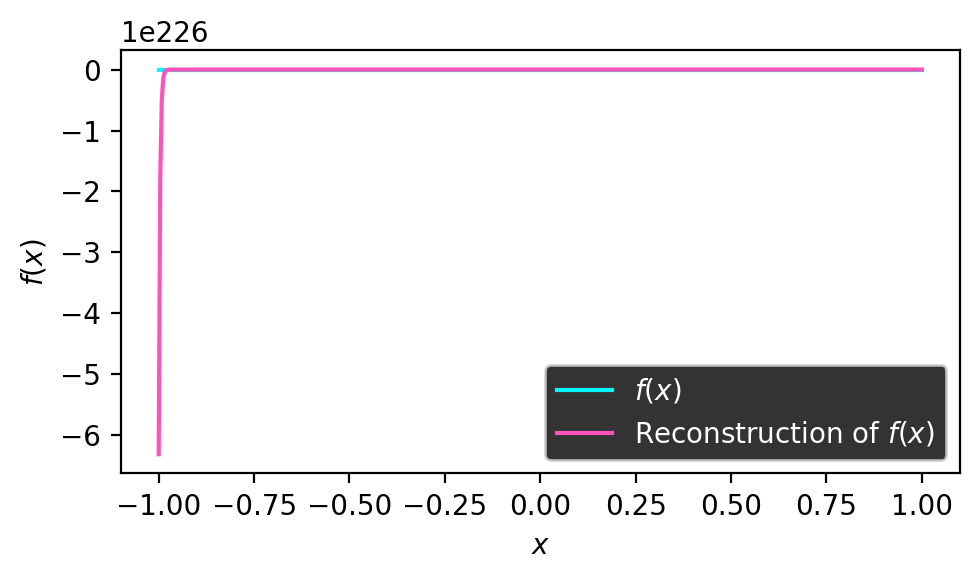

In [2]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

N   = 500
x   = np.linspace(-1, 1, N)
f   = np.exp(x)
f_k = scipy.fft.fft(f)
W = np.zeros((N, N), dtype=complex)

for l in range(N):
    W[:, l] = scipy.fft.fft(scipy.special.chebyt(l)(x))
W_inv = np.linalg.inv(W)
g     = W_inv @ f_k

f_rec = np.poly1d([])
for l, coeff in enumerate(g):
    f_rec += coeff * scipy.special.chebyt(l)

fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
plt.style.use('dark_background')
plt.plot(x, f, label = r"$f(x)$", c = '#08F7FE')
plt.plot(x, f_rec(x), label = r"Reconstruction of $f(x)$", c = '#FE53BB')
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.legend()
plt.tight_layout()
plt.savefig("figures/ipr_failure.png", bbox_inches='tight')
plt.show()

What went wrong? The condition number of W is very high.

In [16]:
np.linalg.cond(W)

2.7244073965482243e+17

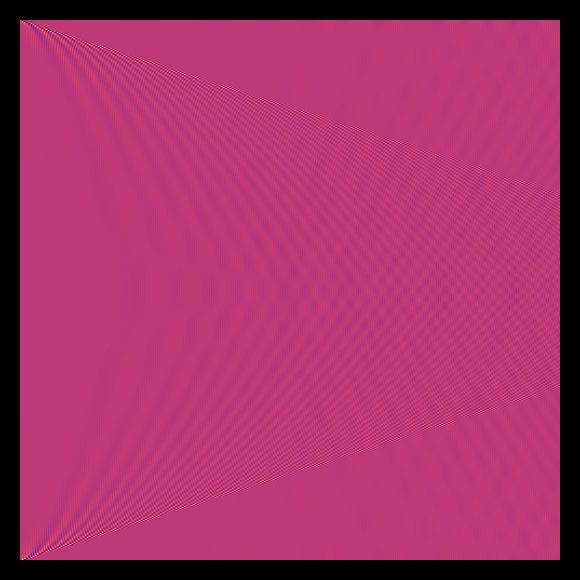

In [7]:

fig, axs = plt.subplots(figsize=(3, 3), dpi=200)
plt.axis("off")
W[0, 0] = 0
plt.imshow(W.real, cmap="magma")

plt.tight_layout()
plt.savefig("figures/ipr_W.png", bbox_inches='tight')
plt.show()

Plot singular values:

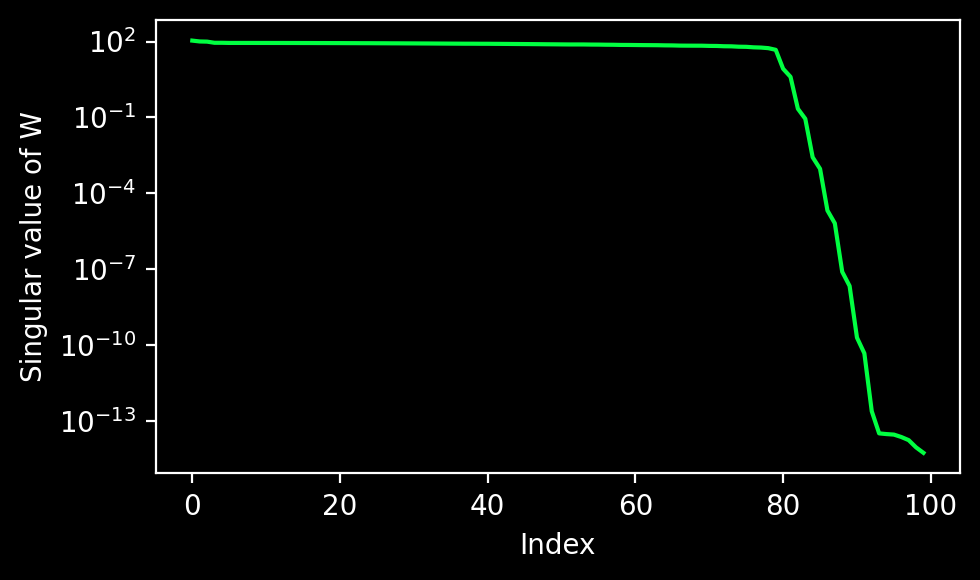

In [38]:
u, s, vh = np.linalg.svd(W)
fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
plt.plot(np.abs(s), c='#00ff41')
plt.yscale("log")
plt.xlabel("Index")
plt.ylabel("Singular value of W")

plt.tight_layout()
plt.savefig("figures/ipr_svd.png", bbox_inches='tight')
plt.show()

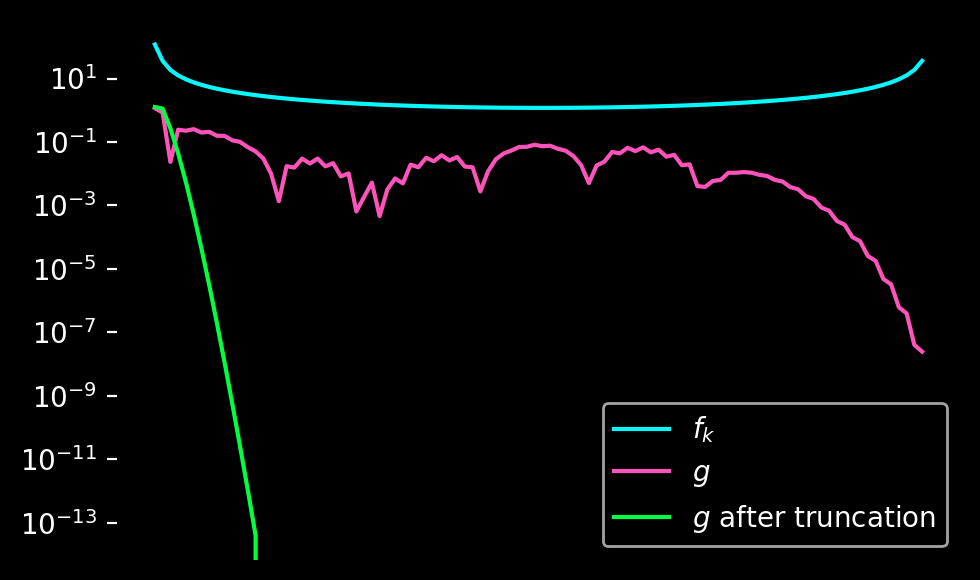

/home/xerox/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


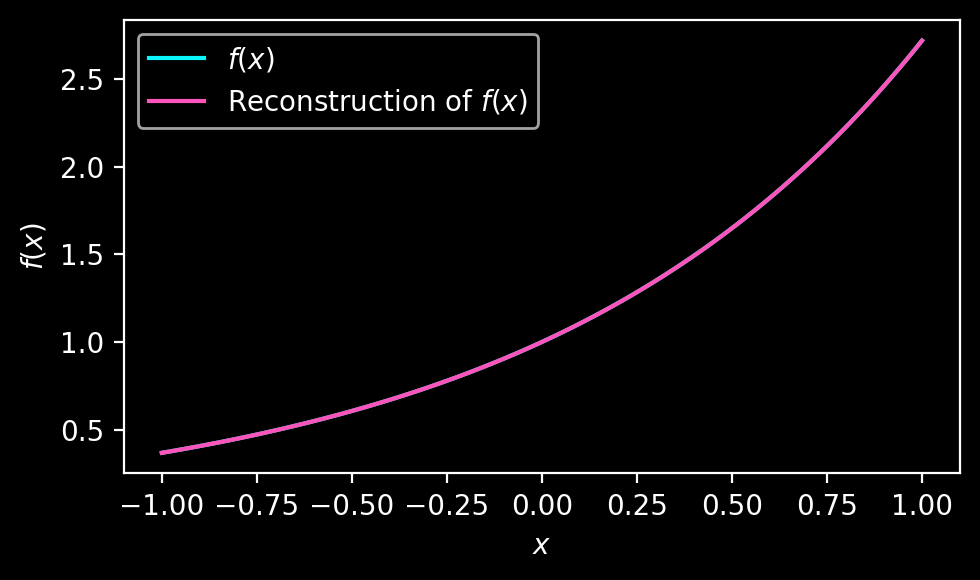

In [33]:
# LU decomposition with pivot
pivot, L, U = scipy.linalg.lu(W, permute_l=False)

# forward substitution to solve for L x y = f_k
y = np.zeros(f_k.size, dtype=complex)
for m, b in enumerate((pivot.T @ f_k).flatten()):
    y[m] = b
    # skip for loop if m == 0
    if m:
        for n in range(m):
            y[m] -= y[n] * L[m,n]
    y[m] /= L[m, m]

# truncation for IPR
c = np.abs(y) < 1000 * np.finfo(float).eps
y[c] = 0

# backward substitution to solve for y = U x
g = np.zeros(f_k.size, dtype=complex)
lastidx = f_k.size - 1  # last index
for midx in range(f_k.size):
    m = f_k.size - 1 - midx  # backwards index
    g[m] = y[m]
    if midx:
        for nidx in range(midx):
            n = f_k.size - 1  - nidx
            g[m] -= g[n] * U[m,n]
    g[m] /= U[m, m]

fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.get_xaxis().set_ticks([])
axs.get_yaxis().set_ticks([])
plt.yscale("log")
plt.plot(np.abs(f_k), label=r"$f_k$", c = '#08F7FE')
plt.plot(np.abs(W_inv @ f_k), label=r"$g$", c = '#FE53BB')
plt.plot(np.abs(g), label=r"$g$ after truncation", c = '#00ff41')
plt.legend()
plt.tight_layout()
plt.savefig("figures/ipr_coefficient_decay.png", bbox_inches='tight')
plt.show()


f_rec = np.poly1d([])
for l, coeff in enumerate(g):
    f_rec += coeff * scipy.special.chebyt(l)

fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
plt.style.use('dark_background')
plt.plot(x, f, label = r"$f(x)$", c = '#08F7FE')
plt.plot(x, f_rec(x), label = r"Reconstruction of $f(x)$", c = '#FE53BB')
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.legend()
plt.tight_layout()
plt.savefig("figures/ipr_success.png", bbox_inches='tight')
plt.show()

/home/xerox/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


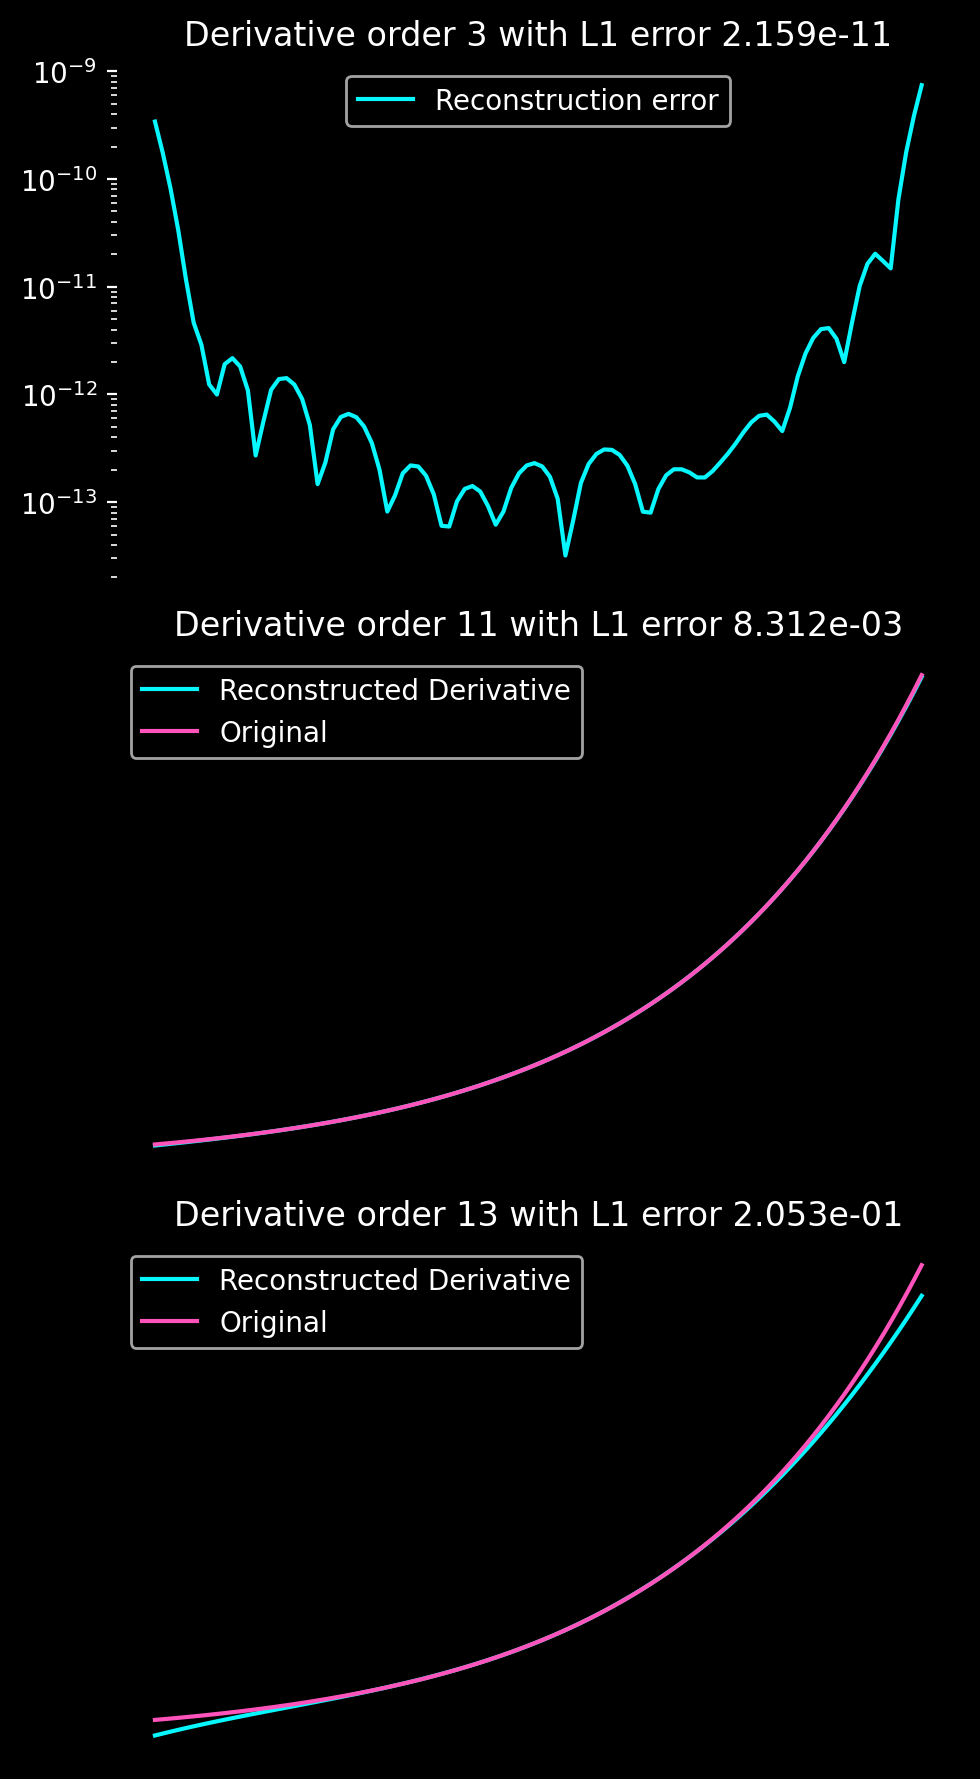

In [3]:


class IPRReconstruction:
    def __init__(self, x, lam = 1, cutoff = 100):
        self.cutoff                 = cutoff
        W                           = self.directW(self.shiftx(x), int(len(x)/2))
        self.p, self.l, self.u      = scipy.linalg.lu(W, permute_l=False)

    def poly(self, N):
        return scipy.special.chebyt(N)

    def reconstruct(self, g):
        f = np.poly1d([])
        for l, coeff in enumerate(g):
            f += coeff * self.poly(l)

        return f

    def __call__(self, x, order = 0):
        return self.rec.deriv(order)((x - self.s)*self.c) * self.c**order

    def directW(self, x, N):
        # Even
        W = np.zeros((2*N, 2*N), dtype=complex)

        for l in range(2*N):
            W[:, l] = scipy.fft.fft(self.poly(l)(x))

        return W


    def shiftx(self, x):
        dx = x[1] - x[0]
        self.a = x[0]
        self.b = x[-1]
        self.s = (self.a + self.b)/2
        self.c = 1 / ((self.b - self.a)/2)
        sx = (x - self.s) * self.c
        return  sx

    def gaussWithTruncation(self, A, B):
        """
        Solve Ax = B using Gaussian elimination and LU decomposition with truncation for stability of IPR
        """
        # LU decomposition with pivot
        p, l, u = scipy.linalg.lu(A, permute_l=False)
        return self.solveLUWithTruncation(B, p, l, u)


    def compute(self, psi, p = None, l = None, u = None):
        B = scipy.fft.fft(psi)

        if p is None:
            p = self.p
        if l is None:
            l = self.l
        if u is None:
            u = self.u

        # forward substitution to solve for Ly = B
        y = np.zeros(B.size, dtype=complex)
        for m, b in enumerate((p.T @ B).flatten()):
            y[m] = b
            # skip for loop if m == 0
            if m:
                for n in range(m):
                    y[m] -= y[n] * l[m,n]
            y[m] /= l[m, m]

        # truncation for IPR
        c = np.abs(y) < self.cutoff * np.finfo(float).eps
        y[c] = 0

        # backward substitution to solve for y = Ux
        x = np.zeros(B.size, dtype=complex)
        lastidx = B.size - 1  # last index
        for midx in range(B.size):
            m = B.size - 1 - midx  # backwards index
            x[m] = y[m]
            if midx:
                for nidx in range(midx):
                    n = B.size - 1  - nidx
                    x[m] -= x[n] * u[m,n]
            x[m] /= u[m, m]
        self.rec = self.reconstruct(x)



L = np.pi
N = 100
x = np.linspace(0, L, N)
def func(x):
    return np.exp(x)
f = func(x)

ipr = IPRReconstruction(x, cutoff=1000)
ipr.compute(f)

# Number of subplots
num_subplots = 3

# Create subplots
fig, axs = plt.subplots(num_subplots, 1,  figsize=(5 , 3* num_subplots), dpi=200)


colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41', # matrix green
]

plt.style.use('dark_background')

# Loop through different subtraction orders
for i, o in enumerate([3, 11, 13]):
    forg = func(x)
    frec = ipr(x,order=o)

    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].get_xaxis().set_ticks([])
    axs[i].get_yaxis().set_ticks([])

    # Plot the sum and the original function in subplots
    axs[i].set_title(f"Derivative order {o} with L1 error {np.mean(np.abs(frec - forg)):3.3e}")

    if i == 0:
        axs[i].set_yscale("log")
        axs[i].plot(x, np.abs(forg - frec), label="Reconstruction error", c = colors[0])
    else:
        axs[i].plot(x, frec, label="Reconstructed Derivative", c = colors[0])
        axs[i].plot(x, forg, label="Original", c = colors[1])
    axs[i].legend()

# Adjust layout
fig.tight_layout()
fig.savefig("figures/ipr_accuracy.png", bbox_inches='tight')


# Now work in higher precision

/home/xerox/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


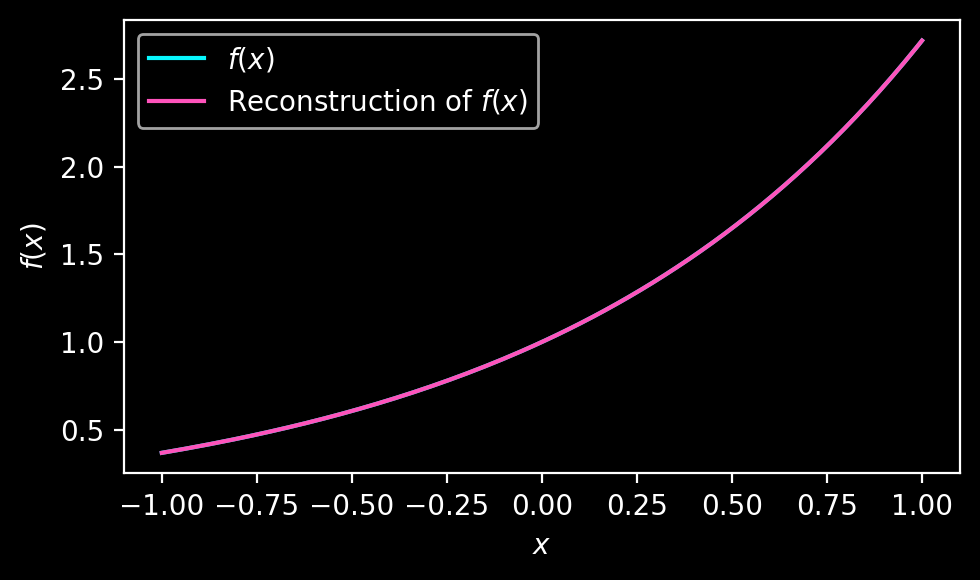

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import mp

import matplotlib.pyplot as plt
from mpmath import mp, chebyt, matrix, lu_solve

mp.dps = 32  # set the precision

N = 128
x = [mp.mpf(i) for i in np.linspace(-1, 1, N)]  # high-precision linspace
f = [mp.exp(i) for i in x]  # compute exp for each x

# Define DFT matrix
def dftmat(N):
    M = mp.matrix(N, N)
    for i in range(N):
        for j in range(N):
            M[i, j] = mp.exp(-2j * mp.pi * i * j / N)
    return M

# Define inverse DFT matrix
def idftmat(N):
    M = mp.matrix(N, N)
    for i in range(N):
        for j in range(N):
            M[i, j] = mp.exp(2j * mp.pi * i * j / N) / N
    return M

# Compute DFT of f
dft = dftmat(N)
f_k = dft * mp.matrix(f) # Ensure f is an mpmath matrix for multiplication

# Initialize an mpmath matrix for W to hold DFT of Chebyshev polynomials
W = mp.matrix(N, N)

for l in range(N):
    # Evaluate Chebyshev polynomial of the first kind of degree l at each point in x
    cheby_values = [mp.chebyt(l, xi) for xi in x]
    # Compute DFT for Chebyshev polynomial values and assign to W
    W[:, l] = dft * mp.matrix(cheby_values)
# Note: Further operations should maintain the use of mpmath for consistency in precision


# Assuming W and f_k are already defined using mpmath
g = mp.lu_solve(W, f_k )  # Inverting W using LU decomposition

# Reconstruct f using Chebyshev polynomials and the coefficients in g
f_rec = [mp.mpf('0') for _ in range(N)]
for l in range(N):
    Tl = [chebyt(l, xi) for xi in x]  # Evaluate Chebyshev polynomial T_l at each point in x
    f_rec = [f_rec[i] + g[l] * Tl[i] for i in range(N)]

# Convert x and f_rec to numpy arrays for plotting
x_float = np.array([float(xi) for xi in x])
f_rec_float = np.array([complex(fi) for fi in f_rec])
f_float = np.array([float(fi) for fi in f])

# Plotting
fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
plt.style.use('dark_background')
plt.plot(x_float, f_float, label = r"$f(x)$", c = '#08F7FE')
plt.plot(x_float, f_rec_float, label = r"Reconstruction of $f(x)$", c = '#FE53BB')
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.legend()
plt.tight_layout()
plt.savefig("figures/ipr_success.png", bbox_inches='tight')
plt.show()

